In [1]:
from collections import Counter
from pprint import pprint
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from helper import Preprocess
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import linalg as LA

from sklearn.manifold import TSNE

In [2]:
FILE_NAME = '64_relu_30_5_adjacentTF_1e-4'
DATA_DIR = Path("../../data/")

we first explore the original graph (before embedding)

In [3]:
data_processor = Preprocess()
df = data_processor.raw2train(DATA_DIR)

G_original = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G_original))

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------
Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 761241
Average degree:  81.9729


We first map the vectors in embedded space to a graph using KNN algorithm

In [4]:
emb_df = pd.read_csv(f'./emb/{FILE_NAME}.csv', index_col=0)
tf_emb_df = emb_df[emb_df['type'] != 0]
emb_df = emb_df.drop(['type'], axis='columns')



In [5]:
# map node index to node name
idx = emb_df.index
idx2name = dict()
for i, name in enumerate(idx):
    idx2name[i] = name
emb = emb_df.to_numpy()

# use KNN to find nearest neighbors of every node
print('Running KNN...')
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(emb)
distance, indices = nbrs.kneighbors(emb)
print('KNN completed!')

# create edgelist
edgelist = []
print('Creating edgelist...')
for i, name in enumerate(idx):
    for j in range(len(indices[i])):
        temp = []
        if j != 0:
            temp.append(name)
            temp.append(idx2name[indices[i][j]])
            temp.append(distance[i][j])
            edgelist.append(temp)

edgelist_df = pd.DataFrame(edgelist)
edgelist_df.columns = ['source', 'target', 'distance']
# edgelist_df['weight'] = edgelist_df['distance'].map(lambda x: 1-x)
edgelist_df.shape

edgelist_df.head()

Running KNN...
KNN completed!
Creating edgelist...


source   target  distance
0  MCHR1   BDKRB1  0.048990
1  MCHR1   CARD16  0.060307
2  MCHR1   CYP7B1  0.063394
3  MCHR1  CCDC74B  0.063494
4  MCHR1    MGST2  0.065220

In [6]:
# G = nx.from_pandas_edgelist(edgelist_df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
G = nx.from_pandas_edgelist(edgelist_df[['source', 'target']], 'source', 'target', create_using=nx.Graph)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 695068
Average degree:  74.8471


In [7]:
# Run Louvein algorithm for clustering
partition = community_louvain.best_partition(G, resolution=2, random_state=0)
max(set(partition.values()))

8

Now we have a clustered network based on the embedding of each node, we create a new column to record class of each node.

In [8]:
emb_df['class'] = emb_df.index.map(lambda x: partition[x])
cluster_df = emb_df[['class']].copy(deep=True)
cluster_df.groupby(['class'])
def is_tf(name):
    if name[-3:] == '_gm':
        return 2
    elif name[-2:] == '_k':
        return 1
    else:
        return 0
cluster_df['is_tf'] = cluster_df.index.map(lambda name: is_tf(name))

gm_cluster_df = cluster_df[cluster_df['is_tf'] == 2]
k_cluster_df = cluster_df[cluster_df['is_tf'] == 1]
gene_cluster_df = cluster_df[cluster_df['is_tf'] == 0]

print('Cluster of K: ', Counter(k_cluster_df['class']))
print('Cluster of GM: ', Counter(gm_cluster_df['class']))
print('Cluster of normal gene: ', Counter(gene_cluster_df['class']))

Cluster of K:  Counter({7: 69})
Cluster of GM:  Counter({7: 69})
Cluster of normal gene:  Counter({3: 4688, 0: 3246, 4: 3214, 1: 2334, 2: 2209, 6: 2053, 5: 481, 8: 209, 7: 1})


In the embedding space, we want to calculate the distance between each cluster and the TF cluster. To save computational power, the distance is calculate as the distance between the middle points of respective clusters

In [9]:
mean_clusters = emb_df.groupby('class').mean()
tf_mean = tf_emb_df.drop('type', axis=1).mean(axis=0).to_numpy()

def get_dist(x):
    return LA.norm(x.to_numpy() - tf_mean)
mean_clusters['distance_to_tf'] = mean_clusters.apply(get_dist, axis=1)
mean_clusters[['distance_to_tf']].sort_values('distance_to_tf')

distance_to_tf
class                
7            0.006282
3            0.889534
8            0.970805
4            1.016545
1            1.052530
5            1.056194
2            1.063087
0            1.069770
6            1.088508

In [10]:
mean_clusters

0         1         2         3         4         5         6  \
class                                                                         
0      0.000020  0.000105  0.180274  0.127272  0.000000  0.000317  0.001225   
1      0.000009  0.001610  0.192227  0.163630  0.001106  0.001331  0.001119   
2      0.000243  0.000311  0.163785  0.139558  0.000197  0.000300  0.000097   
3      0.000000  0.042419  0.132103  0.061800  0.038036  0.000074  0.000244   
4      0.000000  0.109946  0.442231  0.236116  0.137544  0.000000  0.000000   
5      0.000000  0.047500  0.439458  0.251766  0.303493  0.000070  0.000113   
6      0.000000  0.000168  0.176072  0.140857  0.000001  0.000158  0.001006   
7      0.000000  0.052010  0.140728  0.045194  0.002100  0.000000  0.000000   
8      0.000000  0.115563  0.232791  0.089731  0.118384  0.000000  0.000000   

              7         8         9  ...        55        56        57  \
class                                ...                                 
0      0.121642  0.090938  0.156888  ...  0.027559  0.157140  0.064363   
1      0.116052  0.120584  0.167084  ...  0.028587  0.154684  0.065164   
2      0.148031  0.137761  0.159338  ...  0.028155  0.158461  0.065020   
3      0.000873  0.001051  0.172647  ...  0.004600  0.114515  0.016359   
4      0.000000  0.000017  0.343400  ...  0.000034  0.145422  0.032618   
5      0.000000  0.000000  0.332298  ...  0.001242  0.142495  0.034094   
6      0.165657  0.123418  0.137530  ...  0.027036  0.152545  0.062479   
7      0.000000  0.000000  0.175292  ...  0.000383  0.258208  0.001318   
8      0.000000  0.000000  0.339438  ...  0.000000  0.078908  0.108723   

             58        59        60        61        62        63  \
class                                                               
0      0.000012  0.031664  0.000000  0.166462  0.203107  0.071659   
1      0.000287  0.032125  0.000430  0.161224  0.198063  0.069216   
2      0.000030  0.031835  0.000057  0.167585  0.204733  0.072125   
3      0.000132  0.117331  0.135788  0.007746  0.079967  0.001609   
4      0.000000  0.043817  0.077074  0.000091  0.000268  0.049604   
5      0.000000  0.042981  0.073988  0.001353  0.001816  0.046321   
6      0.000049  0.030783  0.000000  0.161426  0.196809  0.069612   
7      0.000000  0.228540  0.273869  0.092985  0.386792  0.002922   
8      0.005450  0.198500  0.026150  0.000000  0.000000  0.018532   

       distance_to_tf  
class                  
0            1.069770  
1            1.052530  
2            1.063087  
3            0.889534  
4            1.016545  
5            1.056194  
6            1.088508  
7            0.006282  
8            0.970805  

[9 rows x 65 columns]

In [11]:

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters.drop('distance_to_tf', axis=1))

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed



Running TSNE...
Mapping names to classes...


0          1  type
MCHR1   32.550842 -27.151089     0
PSMD9  -15.293638 -32.875633     0
CRIP1  -49.440506  33.053097     0
GIMAP4 -60.458824 -13.005536     0
GATM    72.116051  18.150555     0
...           ...        ...   ...
4      -41.666447  31.031662    10
5       12.763397 -67.014282    10
6       56.733730  25.712807    10
7      -77.355896  -6.611520    10
8       12.037183 -50.079166    10

[18582 rows x 3 columns]

In [12]:
Path(f"./result/{FILE_NAME}").mkdir(parents=True, exist_ok=True)

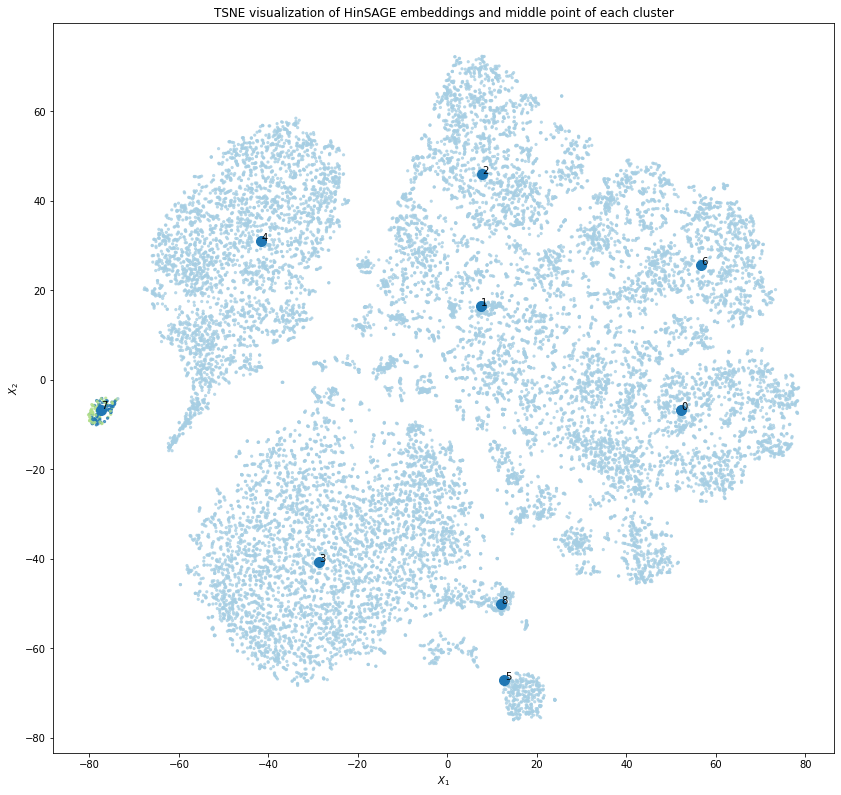

In [13]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=5
)
ax.scatter(
    emb_transformed[emb_transformed['type'] == 10][0],
    emb_transformed[emb_transformed['type'] == 10][1],
    s=100
)

# Annotate ID of each cluster
n_clusters = max(set(partition.values())) + 1
for i in range(n_clusters):
    ax.annotate(str(i), (emb_transformed[emb_transformed['type'] == 10].loc[i][0]+.05, emb_transformed[emb_transformed['type'] == 10].loc[i][1]+.05))
# for i, txt in enumerate(nodes):
#     if txt in target_txts or False:
#         ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))


ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings and middle point of each cluster")

# plt.savefig(f'./result/{FILE_NAME}/cluster.png', dpi=150)
plt.show()

We could also color the graph by the class of each node

Running TSNE...


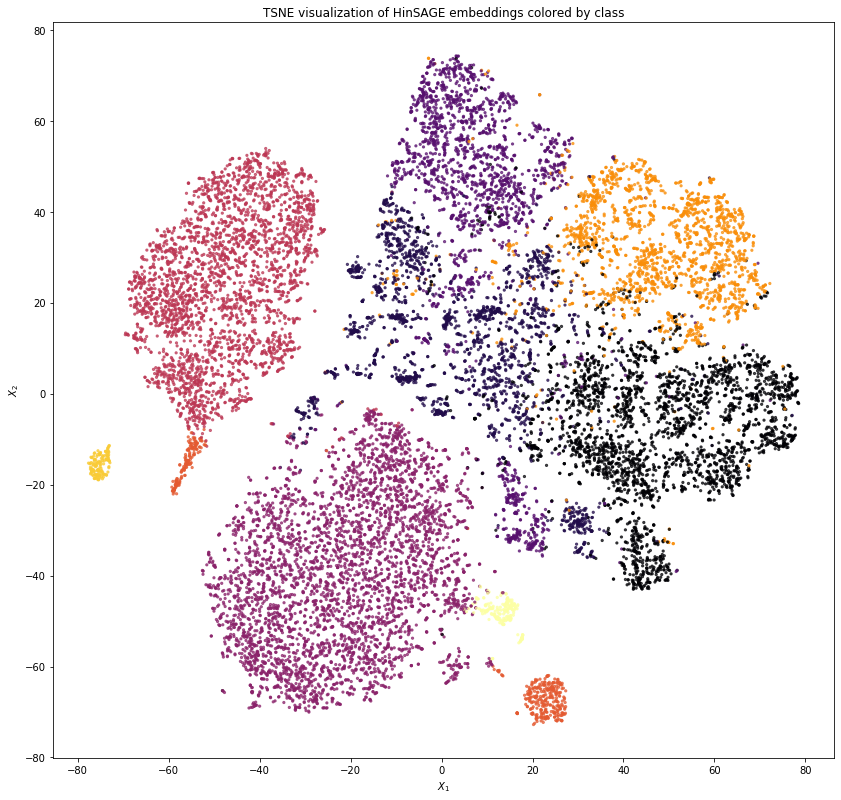

In [14]:
_idx = list(emb_df.columns)[:-1]

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(emb_df[_idx]), index=emb_df.index)
emb_transformed['class'] = emb_df['class']

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["class"],
    cmap="inferno",
    alpha=alpha,
    s=5
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings colored by class")

# plt.savefig(f'./result/{FILE_NAME}/individual_cluster.png', dpi=150)
plt.show()

We could calculate the distance between clusters, the distance is defined as how many hops are needed from one node to another

In [15]:
gms = list(gm_cluster_df.index)
ks = list(k_cluster_df.index)
genes = list(gene_cluster_df.index)

print(len(genes))
cluster_df

18435


class  is_tf
MCHR1         0      0
PSMD9         3      0
CRIP1         4      0
GIMAP4        5      0
GATM          6      0
...         ...    ...
ERCC5         3      0
MARVELD1      2      0
YTHDC2        4      0
SRC           3      0
C1GALT1       0      0

[18573 rows x 2 columns]

In [16]:
shortest_paths = {}
tfs = gms + ks

shortest_paths_df = pd.DataFrame(index=genes, columns=tfs, dtype=np.int16)

for tf in tfs:
    shortest_paths[tf] = nx.shortest_path_length(G_original, source=tf)


In [17]:
shortest_paths_df = pd.DataFrame(shortest_paths)
shortest_paths_df = shortest_paths_df[~shortest_paths_df.index.isin(tfs)]
shortest_paths_df.sort_index(inplace=True)

shortest_paths_cluster = cluster_df[cluster_df.index.isin(shortest_paths_df.index)].sort_index()
# shortest_paths_cluster
shortest_paths_df['cluster'] = shortest_paths_cluster['class']

# Mode
# cluster_rank = shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').agg(lambda x:x.value_counts().index[0]).to_frame().sort_values([0])

# Mean
cluster_rank = shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').mean().to_frame().sort_values([0])

# cluster_rank.to_csv(f'./result/{FILE_NAME}/cluster_rank.csv', index=True, header=True)
cluster_rank

0
cluster          
8        1.773213
4        1.797282
3        1.836477
5        2.249495
6        2.352065
0        2.365152
2        2.749936
1        2.827629
7        3.826087

In [18]:
cluster0 = shortest_paths_df[shortest_paths_df['cluster'] == 0]
maxi_hop = max(shortest_paths_df[list(shortest_paths_df.columns)[:-1]].max())

hop_count_df = pd.DataFrame(data=0, index=['cluster_' + str(i) for i in range(n_clusters)], columns=[i for i in range(maxi_hop+1)])

for i in range(n_clusters):
    _cluster = shortest_paths_df[shortest_paths_df['cluster'] == i].drop(['cluster'], axis=1)
    vals = _cluster.stack().value_counts()
    vals_idx = vals.index.to_list()
    vals_count = vals.to_list()
    counts = dict(zip(vals_idx, vals_count))

    incr = [0] * (maxi_hop + 1)
    # print(counts)
    for key in counts.keys():
        incr[key] += counts[key]
    hop_count_df.loc['cluster_'+str(i)] += incr
    
hop_count_df

0       1       2       3     4    5
cluster_0  0  142104     180  305658     3    3
cluster_1  0   28433     669  289811  1944  131
cluster_2  0   38094      43  266704     1    0
cluster_3  0  246316  261801  137128  1699    0
cluster_4  0  179860  173831   89734   107    0
cluster_5  0     564   49123   16257   434    0
cluster_6  0   91782       6  191525     1    0
cluster_7  0       0      12       0   126    0
cluster_8  0   13050    9286    6503     3    0

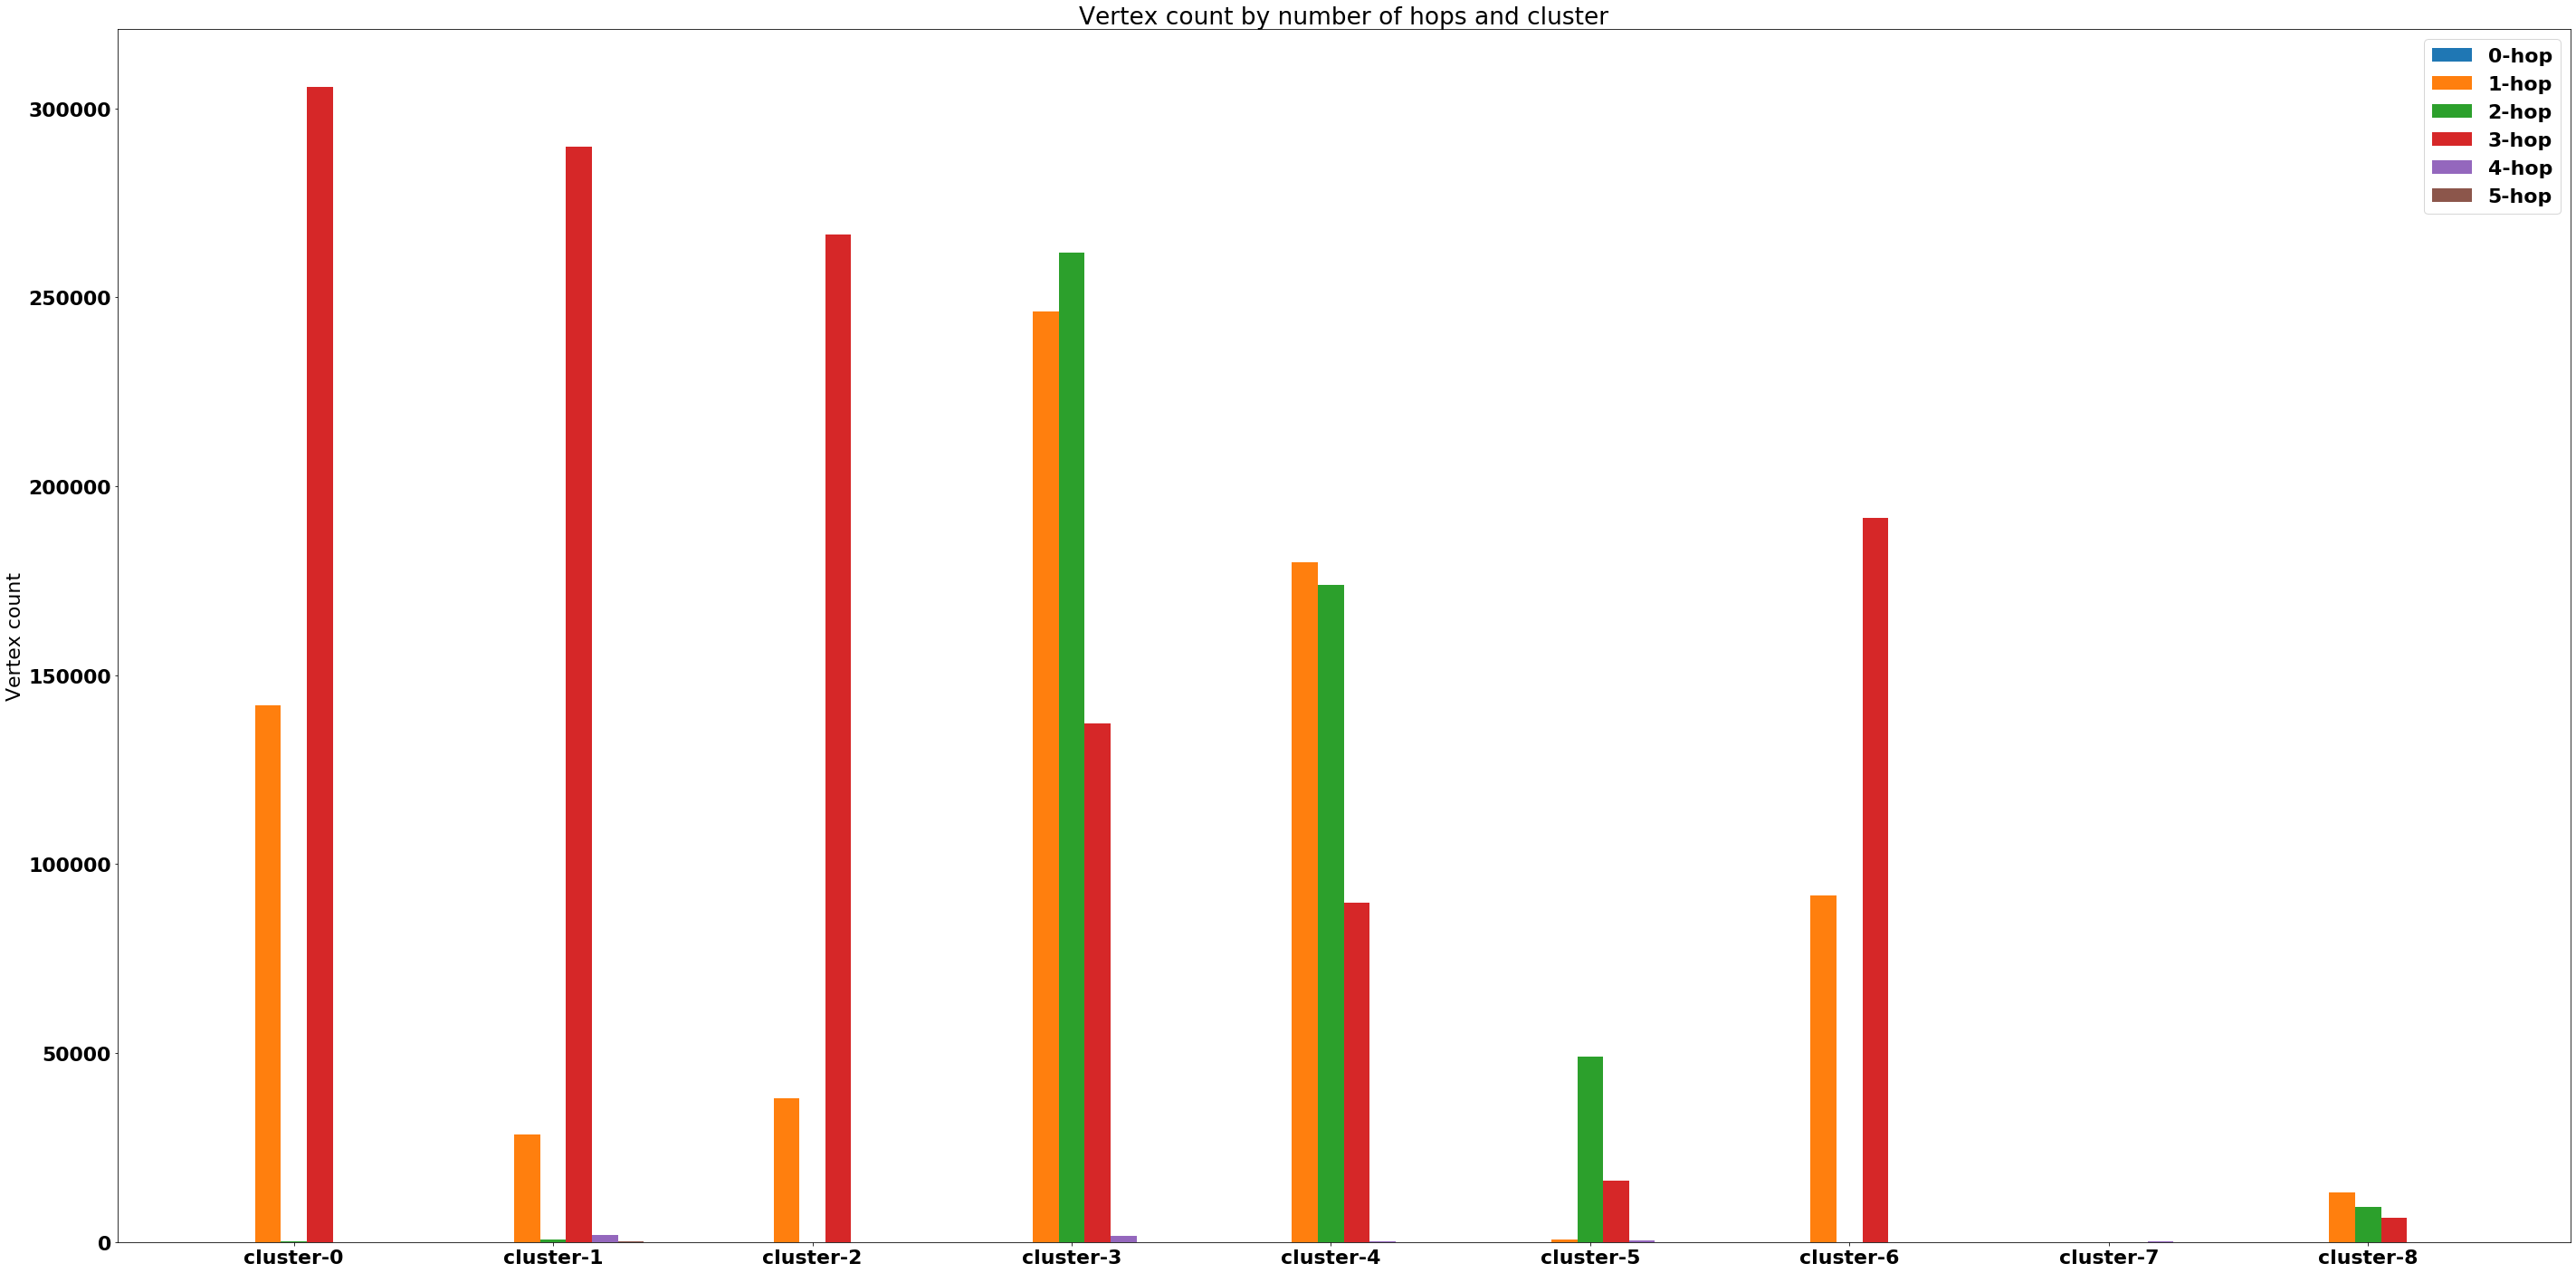

In [19]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

data_to_plot = []
for i in range(maxi_hop+1):
    data_to_plot.append(hop_count_df[i].to_numpy())

# display(data_to_plot)
labels = ['cluster-' + str(i) for i in range(n_clusters)]
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(40)


rects = []
tags = [str(i) + '-hop' for i in range(maxi_hop+1)]
for i in range(maxi_hop+1):
    rects.append(ax.bar(x+i*width - maxi_hop//2 * width, data_to_plot[i].tolist(), width, label=tags[i]))

ax.set_ylabel('Vertex count')
ax.set_title('Vertex count by number of hops and cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# for rect in rects:
#     autolabel(rect)

# autolabel(rects1)
# autolabel(rects2)


fig.tight_layout()
# plt.savefig(f'./result/{FILE_NAME}/barplot.png', dpi=150)
plt.show()